# Part 11. Use virtual layers

An idea is shortly described in the previous part:

> I have a hypothesis that we could use a kind of "virtual layers" when placing nodes. Instead of tracking and updating "previous" nodes, we could calculate "minimal virtual layer" for each of the node. Upon creating a `new_roots` variable, we sort ids by their virtual layers. When creating a `new_layer`, we take no more than `WIDTH` goals with the same virtual layer value. No need to track parents anymore.

To be honest, it came into my mind even before the solution introduced in **Part 9**. Except for small but crucial part: "_when creating a new layer, we take goals with the same virtual layer value_". Without this part, it didn't work properly. But now it's possible. Let's take a look:

1. Every _initial_ root goal would have virtual layer equals to **0**, by definition.
2. Any child or blocker of goal **N** would have virtual layer of **N + 1** or higher.
3. We could take at least one goal at every iteration because virtual layer distribution is dence. For a non-empty list of candidates, there's always at least one goal with the smallest virtual layer.
4. We wouldn't have horisontal or downgoing edges because we don't place candidates with different virtual layers into one real layer.

Let's do it.

In [1]:
import matplotlib.pyplot as plt
from dataclasses import dataclass
from operator import itemgetter
from random import randint
from typing import Any, Callable, Union, Optional

In [2]:
from siebenapp import RenderRow, RenderResult
from sieben_example1 import EXAMPLE as rr0

In [3]:
def draw(rr: RenderResult, min_row: int = 0) -> None:
    xpos: Dict[int, int] = {}
    ypos: Dict[int, int] = {}
    for goal_id, attrs in rr.goals():
        row, col = attrs.get("row", None), attrs.get("col", None)
        xpos[goal_id] = col if col is not None else randint(0, 10)
        ypos[goal_id] = row if row is not None else randint(min_row, 10) 
    for row in rr.rows:
        row_id = row.goal_id
        for edge in row.edges:
            e = edge[0]
            if ypos[row_id] > ypos[e]:
                print(f"downgoing edge: {row_id}@{ypos[row_id]} -> {e}@{ypos[e]}")
            plt.plot([xpos[row_id], xpos[e]], [ypos[row_id], ypos[e]], 'ro-')
        plt.text(xpos[row_id] + 0.1, ypos[row_id], row.name)
    tops = [row.goal_id for row in rr.rows if row.is_switchable]
    plt.plot([xpos[t] for t in tops], [ypos[t] for t in tops], 'bo')
    plt.draw()

## Data structures

We ought to modify `RenderStep.roots` field. Instead of keep simply `int` items (node ids), it should keep pairs of `int` (node id + virtual layer). Instead of using raw `Tuple`, we create a simple DTO for that.

In [4]:
@dataclass
class Candidate:
    node: int
    layer: int      # means virtual layer

@dataclass
class RenderStep:
    rr: RenderResult
    roots: list[Candidate]          # changed type
    layers: list[list[int]]
    previous: dict[int, list[int]]  # left for compatibility with old tube, but could be removed, most probably


def pp(step: RenderStep):
    return [step.roots, step.layers]


def add_if_not(m: dict, m1: dict) -> dict:
    nm = dict(m)
    for k, v in m1.items():
        if nm.get(k, None) is None:
            nm[k] = v
    return nm

# Rendering defaults
WIDTH = 5

## Old algorithm

The following function creates a list of "previous" nodes for every node. It seems to be unneeded in the new version of algorithm, but we still keep it here to use in an old version, for comparison. Also, a new function that calculates virtual layers would look quite similar.

In [5]:
def find_previous(rr: RenderResult) -> dict[int, list[int]]:
    result: dict[int, list[int]] = {g: [] for g in rr.roots}
    to_visit: set[int] = set(rr.roots)
    while to_visit:
        g = to_visit.pop()
        connections = [e[0] for e in rr.by_id(g).edges]
        for g1 in connections:
            to_visit.add(g1)
            result[g1] = result.get(g1, []) + [g]
    return result

A previous version of `tube` function. We need to slightly rewrite it to use modified `RenderStep` class.

In [6]:
def tube0(step: RenderStep):
    new_layer: List[int] = []
    already_added: Set[int] = set(g for l in step.layers for g in l)
    # Changes: goal_id -> candidate.node
    for candidate in step.roots:
        if len(new_layer) >= WIDTH:
            break
        if (all(g in already_added for g in step.previous[candidate.node])):
            new_layer.append(candidate.node)
    new_roots: List[int] = [c.node for c in step.roots[len(new_layer):]] + \
                            [e[0] for gid in new_layer for e in step.rr.by_id(gid).edges]
    # Changes end here
    new_opts: Dict[int, Dict] = {
        goal_id: add_if_not(opts, {
            "row": len(step.layers) if goal_id in new_layer else None,
            "col": new_layer.index(goal_id) if goal_id in new_layer else None
        })
        for goal_id, opts in step.rr.node_opts.items()
    }
    new_layers = step.layers + [new_layer]
    already_added.update(set(g for l in new_layers for g in l))
    # Changes: int -> Candidate
    filtered_roots: List[Candidate] = []
    for g in new_roots:
        if g not in already_added:
            filtered_roots.append(Candidate(g, len(new_layers)))        # Use any value because it doesn't used here
            already_added.add(g)
    
    return RenderStep(
            RenderResult(step.rr.rows, node_opts=new_opts, select=step.rr.select, roots=step.rr.roots),
            filtered_roots,
            new_layers,
            step.previous)

Function `build_with` is also modified to use new data structures.

In [7]:
def build_with0(rr: RenderResult, fn: Callable[[RenderStep], RenderStep]) -> RenderStep:
    step = RenderStep(rr, list([Candidate(g, 0) for g in rr.roots]), [], find_previous(rr))
    while step.roots:
        step = fn(step)
    return step

In [8]:
r0 = build_with0(rr0, tube0)
pp(r0)

[[],
 [[1],
  [2, 3, 4, 5, 40],
  [6, 7, 8, 30, 37],
  [39, 41, 9, 16, 31],
  [32, 33, 34, 35, 36],
  [28, 42, 46, 10, 11],
  [12, 13, 14, 15, 17],
  [19, 20, 24, 25, 26],
  [27, 29, 43, 44, 49],
  [47, 48, 51, 21, 22],
  [18, 45, 50],
  [23],
  [38]]]

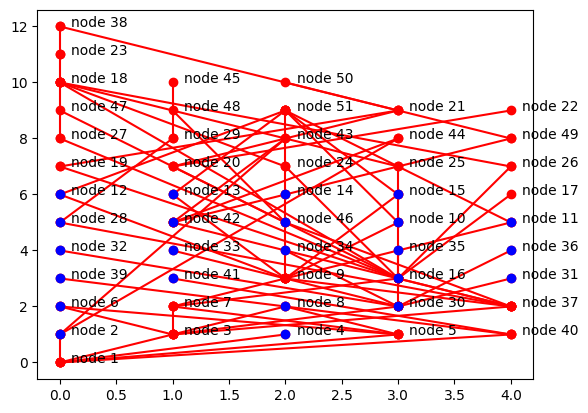

In [9]:
draw(r0.rr)

Okay, we've done with data structures and baseline, let's proceed into new algorithm version.

## Create and use virtual layers

First, we need to assign virtual layers to all nodes. Rules are simple:

1. All initial _root_ nodes would get virtual layer **0**.
2. For every other goal, its virtual layer equals **maximum** of its "previous" nodes virtual layer, plus 1.

In [18]:
def virtual_layers(rr: RenderResult) -> dict[int, int]:
    result: dict[int, int] = {g: 0 for g in rr.roots}
    to_visit: set[int] = set(result.keys())
    while to_visit:
        g = to_visit.pop()
        l = result[g]
        connections = [e[0] for e in rr.by_id(g).edges]
        for g1 in connections:
            to_visit.add(g1)
            result[g1] = max([result.get(g1, 0), l + 1])
    return result

In [19]:
vl1 = virtual_layers(rr0)

In [12]:
def check_virtual_layers(rr: RenderResult, layers: dict[int, int]):
    """Print all incorrect assignments"""
    checked_rows: int = 0
    invalid_rows: list[dict[int, int]] = []
    for row in rr.rows:
        my_layer = layers[row.goal_id]
        children_layers = [(e[0], layers[e[0]]) for e in row.edges]
        wrong_layers = [g for g, l in children_layers if l <= my_layer]
        if wrong_layers:
            invalid_
        checked_rows += 1

    print("Checked rows:", checked_rows)
    print("Invalid rows:", len(invalid_rows))
    return invalid_rows

In [20]:
check_virtual_layers(rr0, vl1)

Checked rows: 51
Invalid rows: 0


[]

Wow, it even works at the first attempt, really? I wasn't sure it would.